In [306]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody
from scipy.special import wofz, expn
from scipy.interpolate import interp1d
from scipy.integrate import trapz

from astro530 import NIntegrate, partition, saha_phi, P_e, Kc_total, K_NaD, opacity, tau_fn

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51'])

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [307]:
def format_sn(x):
    e_str = '{:.1e}'.format(x)
    a = e_str.split('e')[0]
    b = int(e_str.split('e')[-1])
    return a + r'$\times 10^{' +str(b)+ '}$'

def doppler_shift(l0, v): # v in units of c
    return l0 * (1 + v)

In [308]:
D_lines = np.array([5895.932, 5889.959]) * u.AA

In [312]:
source_table = np.loadtxt('./data/CoreS2014.txt').T
S = source_table[1] * u.erg / u.s / u.cm**2 / u.AA/ u.sr

tau_500 = VALIIIC['tau_500'].to_numpy()

h = VALIIIC['h'].to_numpy() * u.km
s = h[0] - h

T = VALIIIC['T'].to_numpy() * u.K

micro = VALIIIC['V'].to_numpy() * u.km/u.s

nH = VALIIIC['n_H'].to_numpy() * u.cm**-3

ne = VALIIIC['n_e'].to_numpy() * u.cm**-3
Pe = ne * c.k_B * T

Pg = VALIIIC['Pgas/Ptotal'].to_numpy() * VALIIIC['Ptotal'].to_numpy() * u.barye

rho = VALIIIC['rho'].to_numpy() * u.g/u.cm**3


B_h = np.zeros(len(h)) * u.erg / u.s / u.cm**2 / u.AA / u.sr
for i, t in enumerate(T):
    B_fn = BlackBody(t) 
    B_h[i] = B_fn(D_lines[0]) * c.c / (D_lines[0])**2

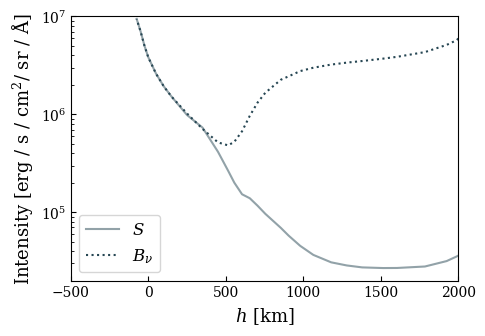

In [313]:
fig, ax1 = plt.subplots(1, 1,figsize = (5,3.5), dpi = 100)
ax1.plot(h, S, alpha = 0.5, label = r'$S$')
ax1.plot(h, B_h, 'C0:', label = r'$B_\nu$')
ax1.set_xlim(-500, 2000)
ax1.set_ylim(2 * 10**4, 10**7)
ax1.semilogy()
ax1.set_xlabel('$h$ [km]')
ax1.set_ylabel('Intensity [erg / s / cm$^2$/ sr / $\mathrm{\AA}$]')
ax1.legend(loc='lower left')

plt.savefig('S_fn.png', bbox_inches='tight')
plt.show()

At $h < 200\, \mathrm{km}$, $S_\nu = B_\nu$ because at depth the effects of scattering are neglible so we can assume that the radiation field is characteristic of the local material conditions.

**True Solar Spectrum (From NEID)**

In [314]:
neid_spec = pd.read_csv('./data/NEID_sodium_order.csv')
wavelen = neid_spec['wavelength'].to_numpy()
flux = neid_spec['flux'].to_numpy()

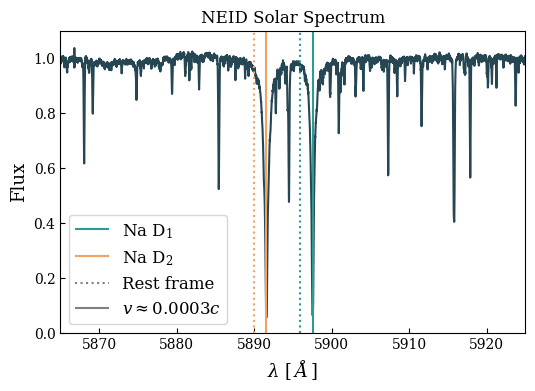

In [315]:
# plt.figure(dpi=100)
# plt.plot(wavelen, flux)
# plt.vlines(D_lines[0].value, 0, 1.1, ls=':', color='C3', label = r'$\lambda_{\mathrm{D}_1} = 5896\, \AA$')
# plt.vlines(D_lines[1].value, 0, 1.1, ls=':', color='C1', label = r'$\lambda_{\mathrm{D}_2} = 5890\, \AA$')
# plt.vlines(D_lines.value * 1.000278, 0, 1.1, color=['C3','C1'])
# plt.xlabel(r'$\lambda\ [\AA]$')
# plt.ylabel(r'Flux')
# plt.ylim(0, 1.1)
# plt.legend(title='Rest frame:')
# plt.show()

# plt.figure(dpi=100)
# plt.plot(wavelen, flux)
# plt.vlines(D_lines[0].value, 0, 1.1, ls=':', color='C3', label = r'$\lambda_{\mathrm{D}_1} = 5896\, \AA$')
# plt.vlines(D_lines[1].value, 0, 1.1, ls=':', color='C1', label = r'$\lambda_{\mathrm{D}_2} = 5890\, \AA$')
# plt.vlines(D_lines.value * 1.000278, 0, 1.1, color=['C3','C1'])
# plt.xlabel(r'$\lambda\ [\AA]$')
# plt.ylabel(r'Flux')
# plt.ylim(0, 1.1)
# #plt.legend(title='Rest frame:')
# plt.xlim(5890, 5893)
# plt.show()

plt.figure(dpi=100)
plt.plot(wavelen, flux)
plt.vlines([D_lines.value[0] * 1.000278, D_lines.value[0]], 0, 1.2, ls=['-', ':'],  color='C1', label = r'Na D$_1$')
plt.vlines([D_lines.value[1] * 1.000278, D_lines.value[1]], 0, 1.2, ls=['-', ':'],  color='C3', label = r'Na D$_2$')

plt.vlines(5000, 0, 1.2, ls=':',  color='gray', label = r'Rest frame')
plt.vlines(5000, 0, 1.2, color='gray', label = r'$v\approx 0.0003 c$')

plt.xlabel(r'$\lambda\ [\, \AA\, ]$')
plt.ylabel(r'Flux')
plt.title('NEID Solar Spectrum')
plt.ylim(0, 1.1)
plt.xlim(5865, 5925)
plt.legend()
#plt.xlim(5896, 5900)
plt.savefig('neid_spec.png', bbox_inches='tight')
plt.show()

In [316]:
departure_table = np.loadtxt('./data/3sdep_extrap.txt').T
depart_coeff = departure_table[1]

In [317]:
wvlen_coarse = np.linspace(5860, 5930, 200) 
wvlen_D = np.concatenate([np.linspace(5889, 5891, 100), np.linspace(5895, 5897, 100)])

wvlen = np.sort(np.array([wvlen_coarse, wvlen_D]).flatten()) * u.AA

In [318]:
def S_tau(tau, S):
    S_tau = interp1d(tau, S) 
    return S_tau

def F_nu(wv, S):
    H = np.zeros_like(wv.value)
    for i in range(len(wv)):
        tau = tau_fn(wv[i])
        source_fn = S_tau(tau, S)
        
        t = np.concatenate([np.logspace(-18, -2, 1000), np.logspace(-2, np.log10(np.max(tau)) - 0.5, 50)])        
        y = 1/2 * source_fn(t) * expn(2, t)
        H[i] = trapz(y, t)                 
    flux = H * (4 * np.pi)
    return flux

In [319]:
def eta(l):
    K_c = Kc_total(l, T, Pg, Pe)
    K_l = 0
    for i in range(1, 3):
        K_l += depart_coeff * K_NaD(l, T, Pg, Pe, nH, rho, micro, i).cgs
    return K_l / K_c

In [320]:
wing = 5885 * u.AA

tau_D1 = tau_fn(D_lines[0])
tau_D2 = tau_fn(D_lines[1])
tau_wing = tau_fn(wing)

eta_D1 = eta(D_lines[0])
eta_D2 = eta(D_lines[1])
eta_wing = eta(wing)

<ipython-input-321-71ceb6d97637>:3: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(h, np.log10(tau_D1),'C1')
<ipython-input-321-71ceb6d97637>:30: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(h, np.log10(tau_D2),'C1')
<ipython-input-321-71ceb6d97637>:57: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(h, np.log10(tau_wing),'C1')


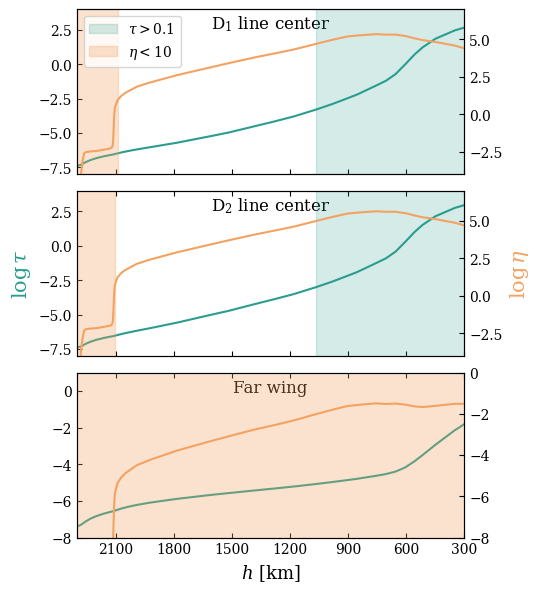

In [321]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(5, 7), dpi=100,gridspec_kw={'hspace': 0.1})

ax1.plot(h, np.log10(tau_D1),'C1')
#plt.hlines(-1, 300, 2300, 'C1', ':')
#ax1.text(300, -8.6, '300', ha='center', size=10)
ax1.set_xlim(2300, 300)
ax1.set_ylim(-8, 4)
#ax1.set_xlabel('$h$ [km]')
ax1.tick_params(labelbottom=False)
#ax1.set_ylabel(r'$\log \tau$', color='C1', size=14)
#plt.legend()
ax1.set_xticks([2100, 1800, 1500, 1200, 900, 600, 300])
ax1.set_title(r'D$_1$ line center', y=0.83, size=12)


ax1b = ax1.twinx()
ax1b.plot(h, np.log10(eta_D1), 'C3')
#ax2.hlines(1, 300, 2300, 'C3', ':')
#plt.xlim(300, 2300)
ax1b.set_ylim(-4, 7)
#ax1b.set_ylabel(r'$\log \eta$', color='C3', size=14)

ax1b.fill_between([0, h[32].value], -10, 7, color='C1', alpha=0.2, label=r'$\tau > 0.1$')
ax1b.fill_between([2300, h[19].value], -8, 7, color='C3', alpha = 0.3, label=r'$\eta < 10$')
#ax1b.fill_between([0, 300], -10, 7, color='k', fc='none', hatch='////', label='h < 300',zorder=9)
ax1b.legend(loc='upper left',fontsize=10)



ax2.plot(h, np.log10(tau_D2),'C1')
#ax2.fill_between([0, 300], -10, 7, color='k', fc='none', hatch='////')
#plt.hlines(-1, 300, 2300, 'C1', ':')
ax2.set_xlim(2300, 300)
ax2.set_ylim(-8, 4)
#ax2.set_xlabel('$h$ [km]')
ax2.set_ylabel(r'$\log \tau$', color='C1', size=15)
ax2.tick_params(labelbottom=False,  top=True)
#plt.legend()
ax2.set_xticks([2100, 1800, 1500, 1200, 900, 600, 300])
ax2.set_title(r'D$_2$ line center', y=0.83, size=12)


ax2b = ax2.twinx()

ax2b.plot(h, np.log10(eta_D2), 'C3')
#ax2.hlines(1, 300, 2300, 'C3', ':')
#plt.xlim(300, 2300)
ax2b.set_ylim(-4, 7)
ax2b.set_ylabel(r'$\log \eta$', color='C3', size=15)

ax2b.fill_between([0, h[32].value], -10, 7, color='C1', alpha=0.2, label=r'$\tau > 0.1$')
ax2b.fill_between([2300, h[18].value], -8, 7, color='C3', alpha = 0.3, label=r'$\eta < 10$')
#ax2b.fill_between([0, 300], -10, 7, color='k', fc='none', hatch='////', label='h < 300',zorder=9)
#ax2b.legend()


ax3.plot(h, np.log10(tau_wing),'C1')
#ax3.fill_between([0, 300], -10, 7, color='k', fc='none', hatch='////')
#plt.hlines(-1, 300, 2300, 'C1', ':')
ax3.set_xlim(2300,300)
ax3.set_ylim(-8, 1)
ax3.set_xlabel('$h$ [km]')
#ax3.set_ylabel(r'$\log \tau$', color='C1', size=14)
#plt.legend()
ax3.set_xticks([2100, 1800, 1500, 1200, 900, 600, 300])
ax3.set_title(r'Far wing', y=0.83, size=12)

ax3b = ax3.twinx()

ax3b.plot(h, np.log10(eta_wing), 'C3')
#ax2.hlines(1, 300, 2300, 'C3', ':')
#plt.xlim(300, 2300)
ax3b.set_ylim(-8, 0)
#ax3b.set_ylabel(r'$\log \eta$', color='C3', size=14)
ax3.tick_params( top=True)

ax3b.fill_between([2300, h[51].value], -8, 7, color='C3', alpha = 0.3, label=r'$\eta < 10$')
ax3b.fill_between([0, h[45].value], -10, 7, color='C1', alpha=0.2, label=r'$\tau > 0.1$')
#ax3b.fill_between([0, 300], -10, 7, color='k', fc='none', hatch='////', label='h < 300',zorder=9)
#ax3b.legend()
plt.savefig('zones.png',bbox_inches='tight')
plt.show()

In [327]:
F = F_nu(wvlen, S) * u.erg / u.s/u.cm**2/u.AA

<Quantity [6.67727986e+09, 6.67636247e+09, 6.67544401e+09, 6.67452441e+09,
           6.67360360e+09, 6.67268153e+09, 6.67175811e+09, 6.67083329e+09,
           6.66990697e+09, 6.66897907e+09, 6.66804950e+09, 6.66711816e+09,
           6.66618496e+09, 6.66524977e+09, 6.66431249e+09, 6.66337299e+09,
           6.66243113e+09, 6.66148674e+09, 6.66053969e+09, 6.65958982e+09,
           6.65863695e+09, 6.65768089e+09, 6.65672143e+09, 6.65575835e+09,
           6.65479140e+09, 6.65382033e+09, 6.65284486e+09, 6.65186467e+09,
           6.65087944e+09, 6.64988881e+09, 6.64889238e+09, 6.64788973e+09,
           6.64688038e+09, 6.64586383e+09, 6.64483952e+09, 6.64380683e+09,
           6.64276508e+09, 6.64171354e+09, 6.64065137e+09, 6.63957767e+09,
           6.63849143e+09, 6.63739153e+09, 6.63627672e+09, 6.63514560e+09,
           6.63399663e+09, 6.63282804e+09, 6.63163787e+09, 6.63042390e+09,
           6.62918360e+09, 6.62791411e+09, 6.62661218e+09, 6.62527406e+09,
           6.62389547e+09

In [254]:
norm_F = F / F[0]

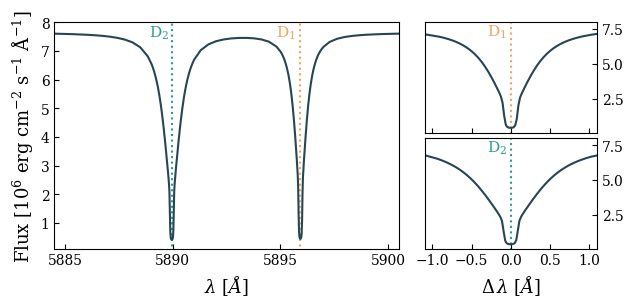

In [358]:
fig = plt.figure(dpi = 100, figsize = (7,3))
gs = GridSpec(2, 2, width_ratios=(2, 1), wspace =0.1, hspace=0.05, figure = fig)

ax1 = plt.subplot(gs[:, 0])
ax1.plot(wvlen, F * 10**-6, c='C0')
ax1.set_xlim(5884.5, 5900.5)
ax1.set_xticks([5885, 5890, 5895, 5900])
ax1.vlines(D_lines, 0, 100, zorder=0, ls=':', color =['C3','C1'])
ax1.text(5894.8, 7.5, 'D$_1$',c='C3', size=11)
ax1.text(5888.9, 7.5, 'D$_2$',c='C1', size=11)
ax1.set_ylim(0.1, 8)

ax1.set_ylabel(r'Flux $[10^{6}$ erg cm$^{-2}$ s$^{-1}$ $\mathrm{\AA}^{-1}]$')
ax1.set_xlabel(r'$\lambda$ [$\AA$]')


ax2 = plt.subplot(gs[0, 1])
ax2.text(-0.3, 7, 'D$_1$',c='C3', size=11)

ax2.plot(wvlen - D_lines[0], F * 1e-6, c='C0')
ax2.vlines(0, 0, 10, zorder=0, ls=':', color ='C3')

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(0.1, 8)

ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.yaxis.tick_right()
ax2.tick_params(labelbottom=False)

ax3 = plt.subplot(gs[1, 1])
ax3.text(-0.3, 7, 'D$_2$',c='C1', size=11)

ax3.plot(wvlen - D_lines[1], F * 1e-6, c='C0')
ax3.vlines(0, 0, 10, zorder=0, ls=':', color = 'C1')

ax3.set_xlim(-1.1, 1.1)
ax3.set_ylim(0.1, 8)

ax3.set_xlabel(r'$\Delta\, \lambda\ [\AA]$')

ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.yaxis.tick_right()
plt.savefig('sodium_doublet_nlte.png',bbox_inches = 'tight')

In [330]:
l= np.array([5884.,5884.17171717, 5884.34343434, 5884.51515152, 5884.68686869
, 5884.85858586, 5885.03030303, 5885.2020202, 5885.37373737, 5885.54545455
, 5885.71717172, 5885.88888889, 5886.06060606, 5886.23232323, 5886.4040404
, 5886.57575758, 5886.74747475, 5886.91919192, 5887.09090909, 5887.26262626
, 5887.43434343, 5887.60606061, 5887.77777778, 5887.94949495, 5888.12121212
, 5888.29292929, 5888.46464646, 5888.63636364, 5888.80808081, 5888.97979798
, 5889.15151515, 5889.32323232, 5889.49494949, 5889.66666667, 5889.75
, 5889.75816327, 5889.76632653, 5889.7744898, 5889.78265306, 5889.79081633
, 5889.79897959, 5889.80714286, 5889.81530612, 5889.82346939, 5889.83163265
, 5889.83838384, 5889.83979592, 5889.84795918, 5889.85612245, 5889.86428571
, 5889.87244898, 5889.88061224, 5889.88877551, 5889.89693878, 5889.90510204
, 5889.91326531, 5889.92142857, 5889.92959184, 5889.9377551, 5889.94591837
, 5889.95408163, 5889.9622449, 5889.97040816, 5889.97857143, 5889.98673469
, 5889.99489796, 5890.00306122, 5890.01010101, 5890.01122449, 5890.01938776
, 5890.02755102, 5890.03571429, 5890.04387755, 5890.05204082, 5890.06020408
, 5890.06836735, 5890.07653061, 5890.08469388, 5890.09285714, 5890.10102041
, 5890.10918367, 5890.11734694, 5890.1255102, 5890.13367347, 5890.14183673
, 5890.15, 5890.18181818, 5890.35353535, 5890.52525253, 5890.6969697
, 5890.86868687, 5891.04040404, 5891.21212121, 5891.38383838, 5891.55555556
, 5891.72727273, 5891.8989899, 5892.07070707, 5892.24242424, 5892.41414141
, 5892.58585859, 5892.75757576, 5892.92929293, 5893.1010101, 5893.27272727
, 5893.44444444, 5893.61616162, 5893.78787879, 5893.95959596, 5894.13131313
, 5894.3030303, 5894.47474747, 5894.64646465, 5894.81818182, 5894.98989899
, 5895.16161616, 5895.33333333, 5895.50505051, 5895.67676768, 5895.75
, 5895.75714286, 5895.76428571, 5895.77142857, 5895.77857143, 5895.78571429
, 5895.79285714, 5895.8,5895.80714286, 5895.81428571, 5895.82142857
, 5895.82857143, 5895.83571429, 5895.84285714, 5895.84848485, 5895.85
, 5895.85714286, 5895.86428571, 5895.87142857, 5895.87857143, 5895.88571429
, 5895.89285714, 5895.9, 5895.90714286, 5895.91428571, 5895.92142857
, 5895.92857143, 5895.93571429, 5895.94285714, 5895.95, 5895.95714286
, 5895.96428571, 5895.97142857, 5895.97857143, 5895.98571429, 5895.99285714
, 5896., 5896.00714286, 5896.01428571, 5896.02020202, 5896.02142857
, 5896.02857143, 5896.03571429, 5896.04285714, 5896.05, 5896.05714286
, 5896.06428571, 5896.07142857, 5896.07857143, 5896.08571429, 5896.09285714
, 5896.1, 5896.19191919, 5896.36363636, 5896.53535354, 5896.70707071
, 5896.87878788, 5897.05050505, 5897.22222222, 5897.39393939, 5897.56565657
, 5897.73737374, 5897.90909091, 5898.08080808, 5898.25252525, 5898.42424242
, 5898.5959596, 5898.76767677, 5898.93939394, 5899.11111111, 5899.28282828
, 5899.45454545, 5899.62626263, 5899.7979798, 5899.96969697, 5900.14141414
, 5900.31313131, 5900.48484848, 5900.65656566, 5900.82828283, 5901.]) * u.AA

In [334]:
F_lte =np.array([8.80191311e-05,8.79971531e-05,8.79729839e-05,8.79463511e-05
,8.79169391e-05,8.78843791e-05,8.78482395e-05,8.78080112e-05
,8.77630914e-05,8.77127617e-05,8.76561602e-05,8.75918705e-05
,8.75188901e-05,8.74357133e-05,8.73404108e-05,8.72301273e-05
,8.71019788e-05,8.69522788e-05,8.67760195e-05,8.65666538e-05
,8.63152020e-05,8.60099164e-05,8.56351456e-05,8.51662818e-05
,8.45711009e-05,8.37888626e-05,8.27570874e-05,8.13680721e-05
,7.94286271e-05,7.66310840e-05,7.24669566e-05,6.61461056e-05
,5.65784089e-05,4.33039606e-05,3.59179340e-05,3.51740894e-05
,3.44254384e-05,3.36635845e-05,3.29000654e-05,3.21342568e-05
,3.13445981e-05,3.05488034e-05,2.97335209e-05,2.88918982e-05
,2.80000110e-05,2.71680331e-05,2.69779220e-05,2.56903056e-05
,2.39674879e-05,2.19677854e-05,2.05815214e-05,2.07785567e-05
,2.25572851e-05,2.53379337e-05,2.85294577e-05,3.17605328e-05
,3.46705633e-05,3.71882109e-05,3.91695602e-05,4.05408492e-05
,4.12812157e-05,4.13483002e-05,4.07515004e-05,3.95075226e-05
,3.76325958e-05,3.52280528e-05,3.23627334e-05,2.96807077e-05
,2.92315954e-05,2.59976369e-05,2.30653035e-05,2.10280553e-05
,2.04772036e-05,2.15916432e-05,2.35662475e-05,2.53755003e-05
,2.67448472e-05,2.78064974e-05,2.87168767e-05,2.95660316e-05
,3.03872913e-05,3.11848315e-05,3.19763808e-05,3.27466808e-05
,3.35101143e-05,3.42736574e-05,3.71786788e-05,5.16200586e-05
,6.27049061e-05,7.01977275e-05,7.50919008e-05,7.83450122e-05
,8.05630703e-05,8.21161818e-05,8.32452566e-05,8.40865508e-05
,8.47192911e-05,8.51959845e-05,8.55632821e-05,8.58444331e-05
,8.60588333e-05,8.62180046e-05,8.63295075e-05,8.63978166e-05
,8.64247562e-05,8.64096016e-05,8.63488501e-05,8.62355922e-05
,8.60583114e-05,8.57987634e-05,8.54270389e-05,8.48961896e-05
,8.41194398e-05,8.29634322e-05,8.11971239e-05,7.83324330e-05
,7.33912592e-05,6.44527570e-05,4.87157738e-05,3.98358707e-05
,3.89165992e-05,3.79927160e-05,3.70632314e-05,3.61191599e-05
,3.51550796e-05,3.41695973e-05,3.31488824e-05,3.20482785e-05
,3.07947342e-05,2.92632791e-05,2.72876507e-05,2.48609911e-05
,2.24124461e-05,2.09961146e-05,2.07414695e-05,2.03638956e-05
,2.11928873e-05,2.28334350e-05,2.49121676e-05,2.71477747e-05
,2.92694544e-05,3.12027694e-05,3.28289302e-05,3.41091276e-05
,3.49518605e-05,3.53951771e-05,3.53858640e-05,3.49254940e-05
,3.40667776e-05,3.27718580e-05,3.11272685e-05,2.91934720e-05
,2.70598950e-05,2.48311452e-05,2.27631302e-05,2.11417585e-05
,2.03550368e-05,2.07875154e-05,2.21354232e-05,2.25041655e-05
,2.49652934e-05,2.73784856e-05,2.93332989e-05,3.08518008e-05
,3.20972474e-05,3.31938917e-05,3.42129836e-05,3.51978408e-05
,3.61615430e-05,3.71050355e-05,3.80345967e-05,4.92595807e-05
,6.48279209e-05,7.36764997e-05,7.85980162e-05,8.14845837e-05
,8.32946707e-05,8.45047359e-05,8.53365105e-05,8.59347581e-05
,8.63810642e-05,8.67238170e-05,8.69926641e-05,8.72079993e-05
,8.73833910e-05,8.75282273e-05,8.76489421e-05,8.77512049e-05
,8.78386203e-05,8.79137807e-05,8.79792816e-05,8.80368087e-05
,8.80876923e-05,8.81329935e-05,8.81735675e-05,8.82101098e-05
,8.82431907e-05,8.82732817e-05,8.83007755e-05,8.83260010e-05]) * u.erg/ u.s/u.cm**2/u.Hz/u.sr * c.c.cgs / l**2

In [339]:
F_lte = F_lte.to(u.erg/ u.s/u.cm**2/u.AA/u.sr)

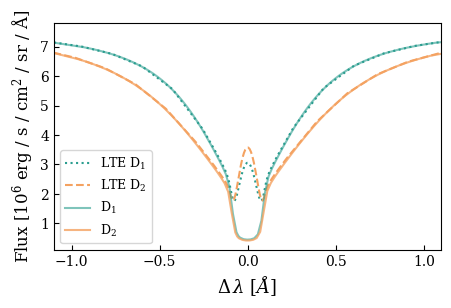

In [363]:
fig = plt.figure(dpi = 100, figsize = (5,3))

plt.plot(l - D_lines[0], F_lte * 1e-6, 'C1:', label='LTE D$_1$')
plt.plot(l - D_lines[1], F_lte * 1e-6, 'C3--', label='LTE D$_2$')
plt.plot(wvlen - D_lines[0], F * 1e-6, 'C1', alpha=0.6,label='D$_1$')
plt.plot(wvlen - D_lines[1], F * 1e-6, 'C3', alpha=0.8,label='D$_2$')

plt.xlim(-1.1, 1.1)
plt.ylim(0.1, 7.8)

plt.xlabel(r'$\Delta\, \lambda\ [\AA]$')
plt.ylabel(r'Flux [$10^6$ erg / s / cm$^2$ / sr / $\mathrm{\AA}$]',size=12)

plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.legend(loc = 'lower left', fontsize=9)
plt.savefig('Na_Ds_nlte.png',bbox_inches = 'tight')

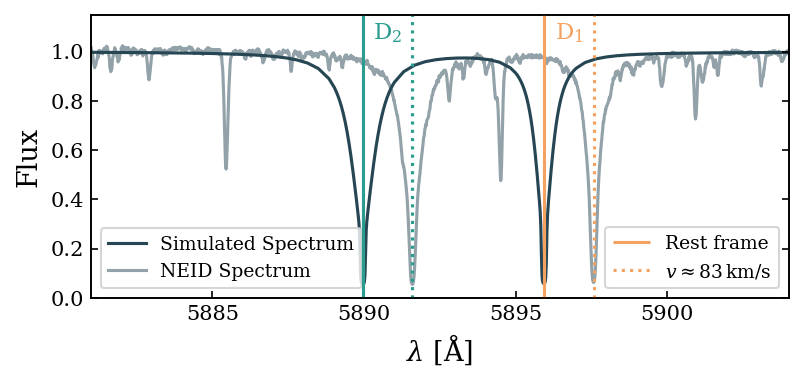

In [373]:
plt.figure(dpi=150, figsize=(6, 2.5))


plt.plot(wvlen, norm_F, 'C0', label = 'Simulated Spectrum')
plt.plot(wavelen, flux, alpha = 0.5, label = 'NEID Spectrum')


plt.xlabel('$\lambda\ [\mathrm{\AA}]$')
plt.ylabel(r'Flux')
#plt.title('NEID Solar Spectrum')
plt.ylim(0, 1.15)
plt.xlim(5881, 5904)

plt.legend(loc = 'lower left', fontsize=9)

ax = plt.gca()
ax1 = ax.twinx()

ax1.vlines(D_lines, 0, 1.2, ls='-',  color=['C3', 'C1'], label = r'Rest frame')
ax1.vlines(D_lines.value * 1.000278, 0, 1.2, ls=':',  color=['C3', 'C1'], label = r'$v \approx 83\,$km/s')
ax1.set_ylim(0, 1.15)
ax1.tick_params(labelright=False)

ax1.text(5896.3, 1.05, 'D$_1$',c='C3', size=11)
ax1.text(5890.3, 1.05, 'D$_2$',c='C1', size=11)

ax1.legend(loc = 'lower right', fontsize=9)
#plt.xlim(5896, 5900)
plt.savefig('neid_spec.png', bbox_inches='tight')
plt.show()

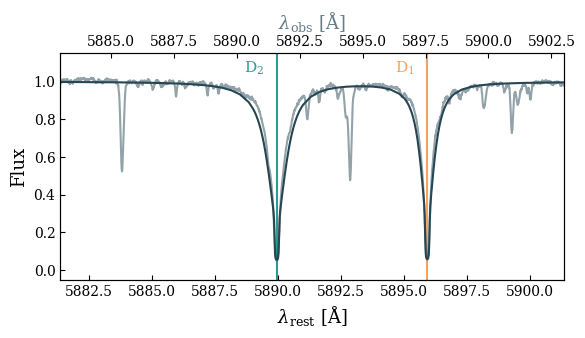

In [365]:
plt.figure(dpi=100, figsize=(6.5, 3))

ax1 = plt.gca()

ax1.vlines(D_lines, -1, 1.2, ls='-',  color=['C3', 'C1'])
ax1.plot(wvlen, norm_F, 'C0', label = 'Simulated Spectrum')
ax1.set_xlim(5883 / (1 + 0.000278), 5903 / (1 + 0.000278))
ax1.set_xlabel('$\lambda_\mathrm{rest}\ [\mathrm{\AA}]$')
ax1.set_ylabel(r'Flux')
ax1.set_ylim(-0.05, 1.15)



#plt.legend(loc = 'lower left')

ax1b = ax1.twiny()

ax1b.plot(wavelen, flux, alpha=0.5, label = 'NEID Spectrum')

ax1b.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\AA}]$', color='C0', alpha = 0.7)

#plt.title('NEID Solar Spectrum')
ax1b.set_ylim(-0.05, 1.15)
ax1b.set_xlim(5883, 5903)
ax1b.text(5896.3, 1.05, 'D$_1$',c='C3', size=11)
ax1b.text(5890.3, 1.05, 'D$_2$',c='C1', size=11)


#ax1.legend(loc = 'lower right')
#plt.xlim(5896, 5900)
plt.savefig('neid_shifted.png', bbox_inches='tight')
plt.show()

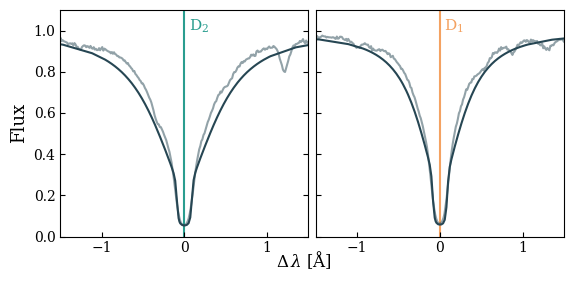

In [364]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize = (6.5,3), dpi=100, gridspec_kw={'wspace': 0.03})

ax1.plot(wvlen - D_lines[0], norm_F, 'C0')
ax1.plot(wavelen * (1 - 0.000278) - D_lines[0].value, flux, alpha = 0.5)

ax1.text(0.05, 1, 'D$_1$',c='C3', size=11)
ax1.vlines(0, 0, 10, zorder=0, ls='-', color ='C3')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(0, 1.1)

ax2.plot(wvlen - D_lines[1], norm_F, 'C0')
ax2.plot(wavelen * (1 - 0.000278) - D_lines[1].value, flux, alpha = 0.5)
ax2.text(0.05, 1, 'D$_2$',c='C1', size=11)
ax2.vlines(0, 0, 10, zorder=0, ls='-', color ='C1')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Flux')

ax2.tick_params(right=True)
ax1.tick_params(labelleft=False)
fig.supxlabel('$\Delta\, \lambda\ [\mathrm{\AA}]$')
plt.savefig('neid_doublets.png', bbox_inches='tight')
plt.show()

In [135]:
VALIIIC = pd.read_pickle('./data/VALIIIC_atm.pkl')

tau_500 = VALIIIC['tau_500'].to_numpy()

h = VALIIIC['h'].to_numpy() * u.km
s = h[0] - h

T = VALIIIC['T'].to_numpy() * u.K

micro = VALIIIC['V'].to_numpy() * u.km/u.s

nH = VALIIIC['n_H'].to_numpy() * u.cm**-3

ne = VALIIIC['n_e'].to_numpy() * u.cm**-3
Pe = ne * c.k_B * T

Pg = VALIIIC['Pgas/Ptotal'].to_numpy() * VALIIIC['Ptotal'].to_numpy() * u.barye

rho = VALIIIC['rho'].to_numpy() * u.g/u.cm**3

In [136]:
def opacity(l):
    K = Kc_total(l, T, Pg, Pe)
    for i in range(1, 3):
        K += depart_coeff * K_NaD(l, T, Pg, Pe, nH, rho, micro, i).cgs
    return K

def tau_fn(l):
    K = opacity(l)
    tau = np.array([trapz(K[:i+1] * rho[:i+1], s[:i+1]) for i in range(len(s))])
    return tau

def S_tau(tau, S):
    S_tau = interp1d(tau, S) 
    return S_tau

def F_nu(wv, S):
    H = np.zeros_like(wv.value)
    for i in range(len(wv)):
        tau = tau_fn(wv[i])
        source_fn = S_tau(tau, S)
        
        t = np.concatenate([np.logspace(-18, -2, 1000), np.logspace(-2, np.log10(np.max(tau)) - 0.5, 50)])        
        y = 1/2 * source_fn(t) * expn(2, t)
        H[i] = trapz(y, t)                 
    flux = H * (4 * np.pi)
    return flux

In [206]:
K_NaD1 = K_NaD(D_lines[0], T, Pg, Pe, nH, rho, micro, 1).cgs
K_NaD2 = K_NaD(D_lines[1], T, Pg, Pe, nH, rho, micro, 2).cgs

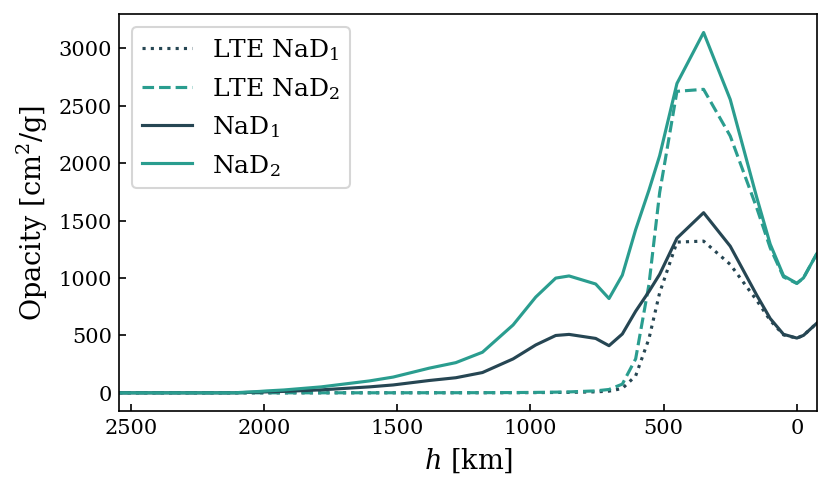

In [229]:
plt.figure(figsize=(6, 3.5),dpi=150)
plt.plot(h, K_NaD1, ls=':', label = 'LTE NaD$_1$')
plt.plot(h, K_NaD2, ls='--', label = 'LTE NaD$_2$')
plt.plot(h, depart_coeff * K_NaD1, c = 'C0', label = 'NaD$_1$')
plt.plot(h, depart_coeff * K_NaD2, c = 'C1', label = 'NaD$_2$')

plt.ylabel('Opacity [cm$^2$/g]')
plt.xlabel('$h$ [km]')
plt.xlim(np.max(h).value, np.min(h).value)

plt.legend()
plt.savefig('NLTE_K.png',bbox_inches='tight')

In [137]:
F = F_nu(wvlen, S)
norm_F = norm_F = F / F[0]

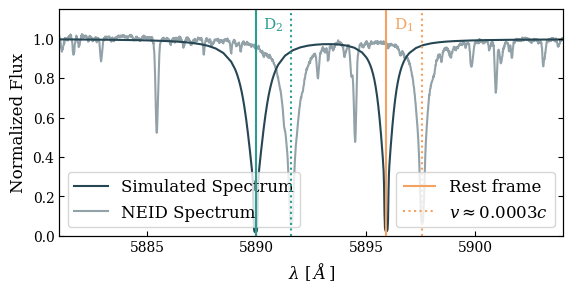

In [138]:
plt.figure(dpi=100, figsize=(6.5, 3))


plt.plot(wvlen, norm_F, 'C0', label = 'Simulated Spectrum')
plt.plot(wavelen, flux, alpha = 0.5, label = 'NEID Spectrum')


plt.xlabel(r'$\lambda\ [\, \AA\, ]$')
plt.ylabel(r'Normalized Flux')
#plt.title('NEID Solar Spectrum')
plt.ylim(0, 1.15)
plt.xlim(5881, 5904)

plt.legend(loc = 'lower left')

ax = plt.gca()
ax1 = ax.twinx()

ax1.vlines(D_lines, 0, 1.2, ls='-',  color=['C3', 'C1'], label = r'Rest frame')
ax1.vlines(D_lines.value * 1.000278, 0, 1.2, ls=':',  color=['C3', 'C1'], label = r'$v\approx 0.0003 c$')
ax1.set_ylim(0, 1.15)
ax1.tick_params(labelright=False)

ax1.text(5896.3, 1.05, 'D$_1$',c='C3', size=11)
ax1.text(5890.3, 1.05, 'D$_2$',c='C1', size=11)

ax1.legend(loc = 'lower right')
#plt.xlim(5896, 5900)
plt.savefig('neid_spec.png', bbox_inches='tight')
plt.show()

Text(0.5, 0.01, '$\\Delta\\, \\lambda\\ [\\mathrm{\\AA}]$')

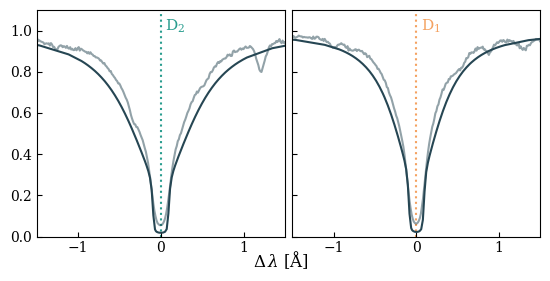

In [139]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize = (6.5,3), dpi=100, gridspec_kw={'wspace': 0.03})

ax1.plot(wvlen - D_lines[0], norm_F, 'C0')
ax1.plot(wavelen * (1 - 0.000278) - D_lines[0].value, flux, alpha = 0.5)

ax1.text(0.05, 1, 'D$_1$',c='C3', size=11)
ax1.vlines(0, 0, 10, zorder=0, ls=':', color ='C3')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(0, 1.1)

ax2.plot(wvlen - D_lines[1], norm_F, 'C0')
ax2.plot(wavelen * (1 - 0.000278) - D_lines[1].value, flux, alpha = 0.5)
ax2.text(0.05, 1, 'D$_2$',c='C1', size=11)
ax2.vlines(0, 0, 10, zorder=0, ls=':', color ='C1')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(0, 1.1)

ax1.tick_params(labelleft=False)
fig.supxlabel('$\Delta\, \lambda\ [\mathrm{\AA}]$')